<a href="https://colab.research.google.com/github/ArindamRoy23/DSBA_T2_Ensemble_Learning_DT_Scratch/blob/feature_Project/Ensemble_Project_Airbnb_pricing_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import urllib
import io

from scipy.stats import chi2_contingency

from sklearn.preprocessing import QuantileTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
!pip install xgboost
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score, make_scorer

In [3]:
data = pd.read_csv('/content/AB_NYC_2019.csv')

In [ ]:
#df = pd.read_csv('AB_NYC_2019.csv')

In [ ]:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [ ]:
data.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


#descriptive analysis

In [4]:
print(pd.to_datetime(data['last_review']).min())
print(pd.to_datetime(data['last_review']).max())

2011-03-28 00:00:00
2019-07-08 00:00:00


In [5]:
#transform datetype
data['last_review'] = pd.to_datetime(data['last_review'])

In [ ]:
data.shape

(48895, 16)

In [ ]:
data.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [6]:
#fill the null value
reference_date = pd.to_datetime('2019-12-31')

# create a new column "recency_of_review" that contains the difference in days between "last_review" and reference_date
data['recency_of_review'] = (reference_date - data['last_review']).dt.days

# replace null values in "recency_of_review" with random values between 3500 and 4000
data['recency_of_review'].fillna(value=np.random.randint(3500, 3700), inplace=True)

In [8]:
data['reviews_per_month'].describe()

count    38843.000000
mean         1.373221
std          1.680442
min          0.010000
25%          0.190000
50%          0.720000
75%          2.020000
max         58.500000
Name: reviews_per_month, dtype: float64

In [9]:
#fill the null value with median
data['reviews_per_month'].fillna(value=0.7, inplace=True)

In [10]:
data = data.dropna()

In [11]:
data = data.drop(columns = ['id','host_id','name','host_name','last_review'])

In [12]:
data.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
recency_of_review                 0
dtype: int64

In [ ]:
data['neighbourhood_group'].nunique()

5

In [ ]:
data['neighbourhood'].nunique()

218

In [ ]:
data['neighbourhood_group'].value_counts()

Manhattan        16621
Brooklyn         16439
Queens            4572
Bronx              875
Staten Island      314
Name: neighbourhood_group, dtype: int64

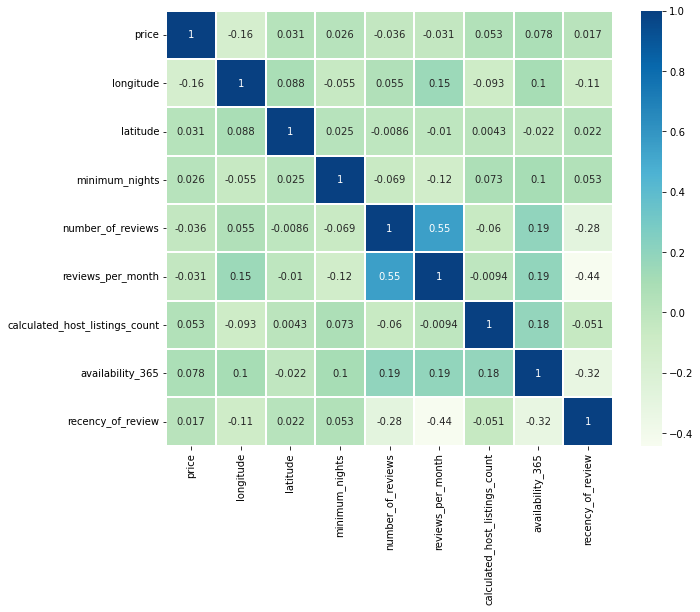

In [ ]:
#Heatmap for Quantitative
quanti=data[['price','longitude','latitude','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365','recency_of_review']]
sns.heatmap(quanti.corr(),annot=True,cmap='GnBu',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

#Alternative variable = reviews_per_month x number_of_reviews ?

Text(0.5, 1.0, 'Density and distribution of prices for each neighberhood_group')

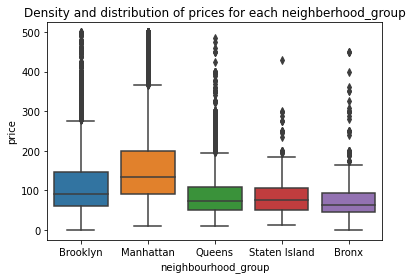

In [ ]:
#we can see from our statistical table that we have some extreme values, therefore we need to remove them for the sake of a better visualization

#creating a sub-dataframe with no extreme values / less than 500
sub_data=data[data.price < 500]
#using violinplot to showcase density and distribtuion of prices 
viz_neighbourhoodprices=sns.boxplot(data=sub_data, x='neighbourhood_group', y='price')
viz_neighbourhoodprices.set_title('Density and distribution of prices for each neighberhood_group')

In [ ]:
#finding out top 10 neighbourhoods
data.neighbourhood.value_counts().head(10)

Williamsburg          3163
Bedford-Stuyvesant    3141
Harlem                2204
Bushwick              1942
Hell's Kitchen        1528
East Village          1489
Upper West Side       1482
Upper East Side       1405
Crown Heights         1265
Midtown                986
Name: neighbourhood, dtype: int64

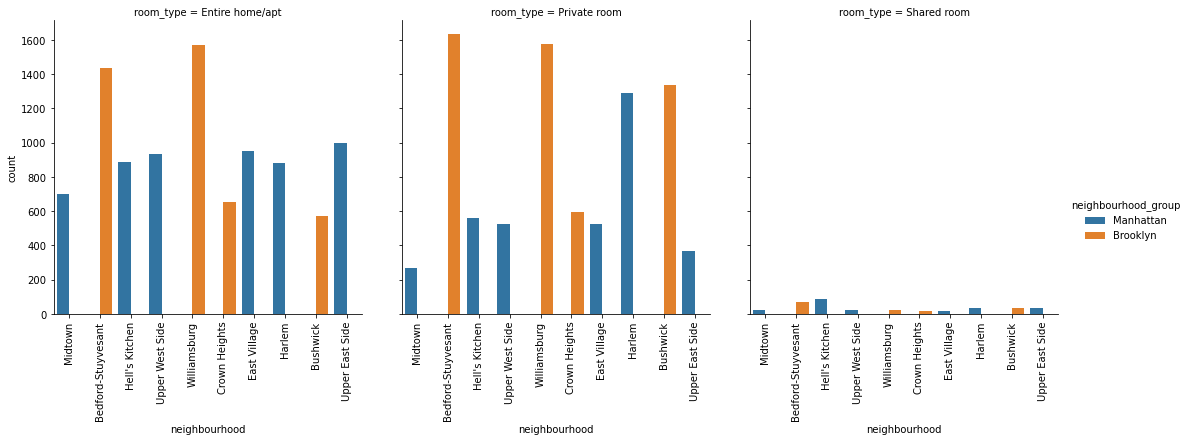

In [ ]:
#let's now combine this with our boroughs and room type for a rich visualization we can make

#grabbing top 10 neighbourhoods for sub-dataframe
sub_topneighbourhood=data.loc[data['neighbourhood'].isin(['Williamsburg','Bedford-Stuyvesant','Harlem','Bushwick',
                 'Upper West Side','Hell\'s Kitchen','East Village','Upper East Side','Crown Heights','Midtown'])]
#using catplot to represent multiple interesting attributes together and a count
viz_topneighbourhood=sns.catplot(x='neighbourhood', hue='neighbourhood_group', col='room_type', data=sub_topneighbourhood, kind='count')
viz_topneighbourhood.set_xticklabels(rotation=90)

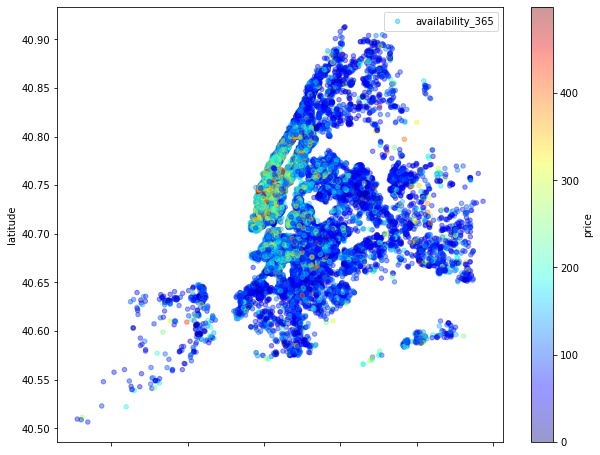

In [ ]:
#let's what we can do with our given longtitude and latitude columns

#let's see how scatterplot will come out 
viz_longlat=sub_data.plot(kind='scatter', x='longitude', y='latitude', label='availability_365', c='price',
                  cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, figsize=(10,8))
viz_longlat.legend()

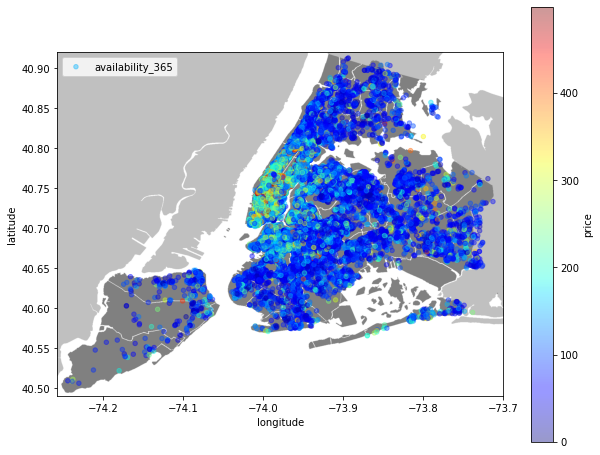

In [ ]:
#initializing the figure size
plt.figure(figsize=(10,8))

#loading the png NYC image found on Google and saving to my local folder along with the project
i=urllib.request.urlopen('https://upload.wikimedia.org/wikipedia/commons/e/ec/Neighbourhoods_New_York_City_Map.PNG').read()
nyc_img=plt.imread(io.BytesIO(i))

#scaling the image based on the latitude and longitude max and mins for proper output
plt.imshow(nyc_img,zorder=0,extent=[-74.258, -73.7, 40.49,40.92])
ax=plt.gca()

#using scatterplot again
sub_data.plot(kind='scatter', x='longitude', y='latitude', label='availability_365', c='price', ax=ax, 
           cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, zorder=5)

plt.legend()
plt.show()


C:\Users\darconect\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Neighbourhood Group')

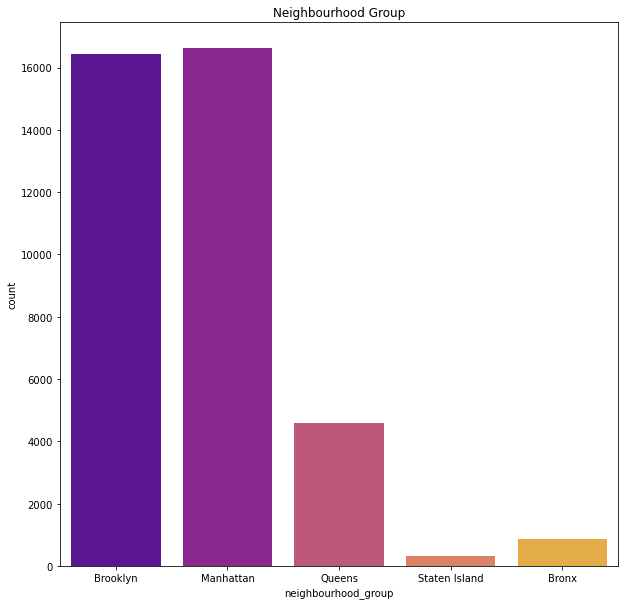

In [ ]:
sns.countplot(data['neighbourhood_group'], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.title('Neighbourhood Group')

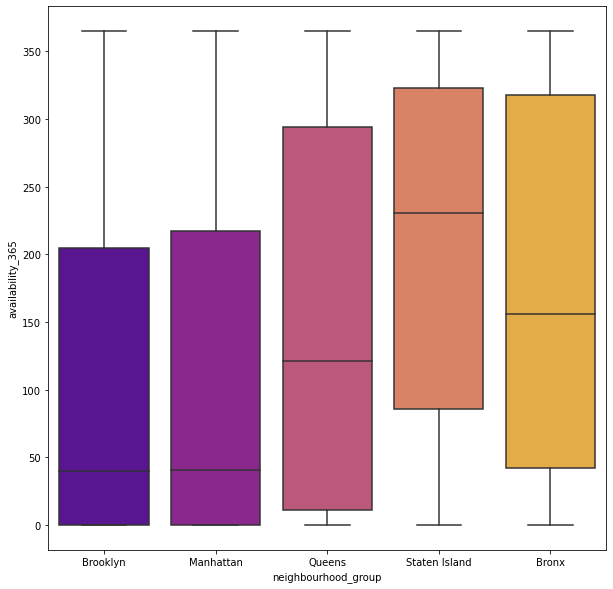

In [ ]:
plt.figure(figsize=(10,10))
ax = sns.boxplot(data=data, x='neighbourhood_group',y='availability_365',palette='plasma')

C:\Users\darconect\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


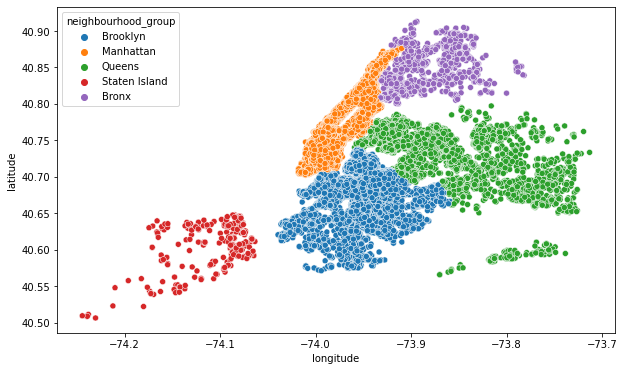

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(data.longitude,data.latitude,hue=data.neighbourhood_group)
plt.ioff()

<Figure size 2160x2160 with 0 Axes>

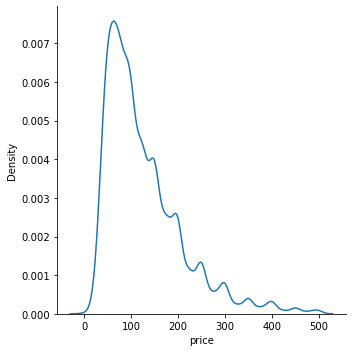

In [ ]:
plt.figure(figsize=(30, 30))
sns.displot(sub_data, x="price", kind="kde")

<Figure size 2160x2160 with 0 Axes>

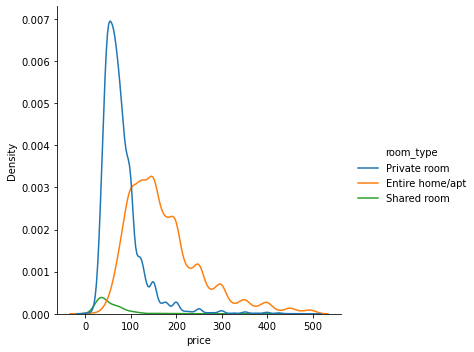

In [ ]:
plt.figure(figsize=(30, 30))
sns.displot(sub_data, x="price", hue="room_type", kind="kde")

<Figure size 2160x2160 with 0 Axes>

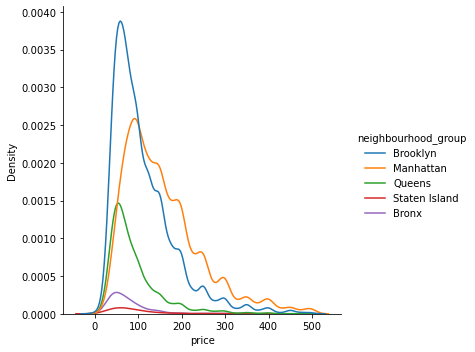

In [ ]:
plt.figure(figsize=(30, 30))
sns.displot(sub_data, x="price", hue="neighbourhood_group", kind="kde")

<AxesSubplot:xlabel='room_type', ylabel='price'>

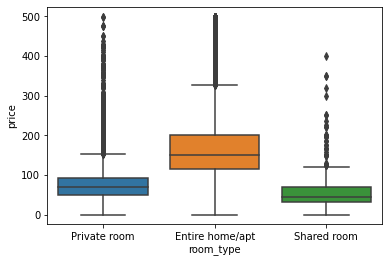

In [ ]:
sns.boxplot(data=sub_data, y="price",x="room_type")

Text(0, 0.5, 'Flats')

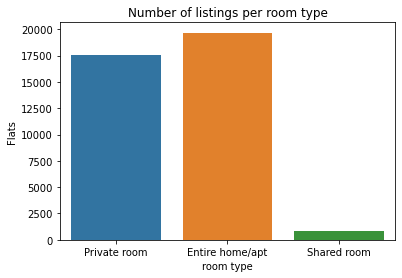

In [ ]:
sns.countplot(x="room_type", data=sub_data)
plt.title('Number of listings per room type')
plt.xlabel('room type')
plt.ylabel('Flats')

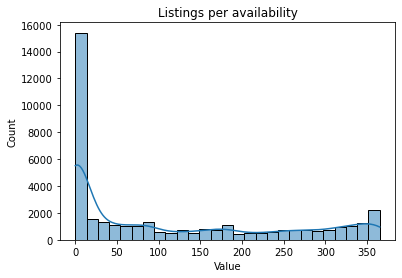

In [ ]:
sns.histplot(data['availability_365'], kde=True)

# add labels and title
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Listings per availability')

# show the plot
plt.show()

Text(0, 0.5, 'Count')

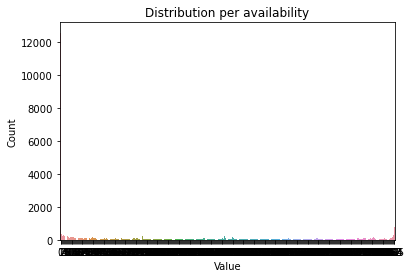

In [ ]:
sns.countplot(x="availability_365", data=sub_data)
plt.title('Distribution per availability')
plt.xlabel('Value')
plt.ylabel('Count')

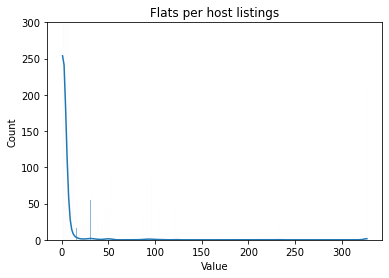

In [ ]:
sns.histplot(data['calculated_host_listings_count'], kde=True)

# add labels and title
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Flats per host listings')
plt.ylim(0,300)
# show the plot
plt.show()

Text(0, 0.5, 'Count')

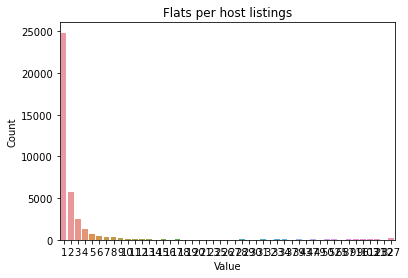

In [ ]:
sns.countplot(x="calculated_host_listings_count", data=sub_data)
plt.title('Flats per host listings')
plt.xlabel('Value')
plt.ylabel('Count')

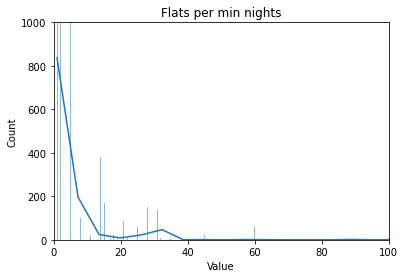

In [ ]:
sns.histplot(data['minimum_nights'], kde=True)

# add labels and title
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Flats per min nights')
plt.ylim(0,1000)
plt.xlim(0,100)
# show the plot
plt.show()

Text(0, 0.5, 'Flats')

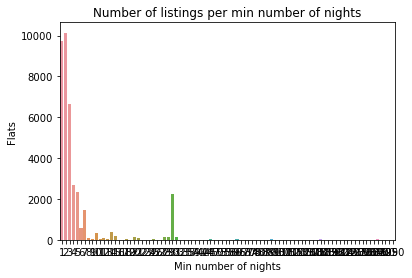

In [ ]:
sns.countplot(x="minimum_nights", data=sub_data)
plt.title('Number of listings per min number of nights')
plt.xlabel('Min number of nights')
plt.ylabel('Flats')

Text(0, 0.5, 'Average price')

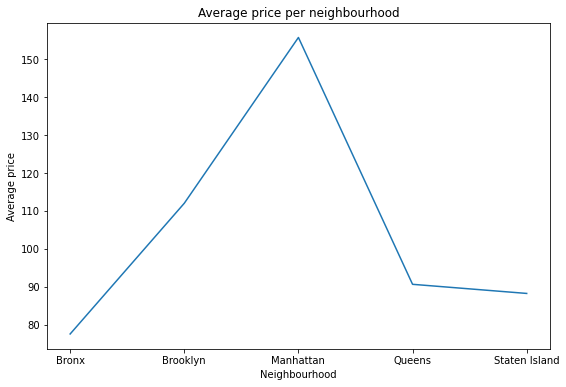

In [ ]:
_, ax = plt.subplots(figsize=(9, 6))
ax.plot(data[data['price'] < 500].groupby('neighbourhood_group').mean()['price'])
plt.title('Average price per neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Average price')

Text(0, 0.5, 'Average price')

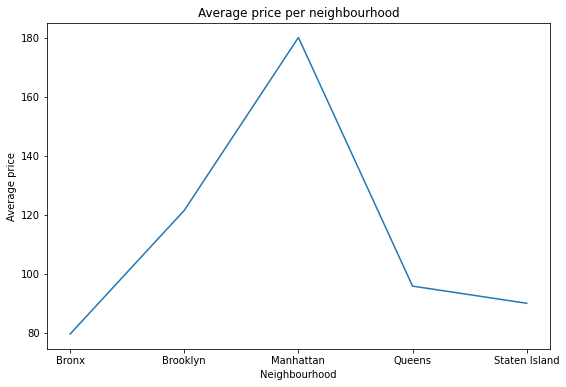

In [ ]:
_, ax = plt.subplots(figsize=(9, 6))
ax.plot(data.groupby('neighbourhood_group').mean()['price'])
plt.title('Average price per neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Average price')

Text(0, 0.5, 'Average price')

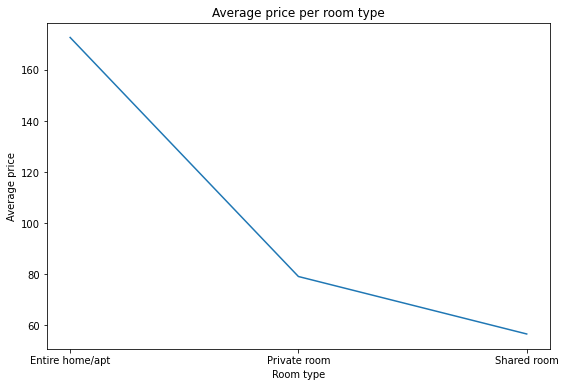

In [ ]:
_, ax = plt.subplots(figsize=(9, 6))
ax.plot(data[data['price'] < 500].groupby('room_type').mean()['price'])
plt.title('Average price per room type')
plt.xlabel('Room type')
plt.ylabel('Average price')

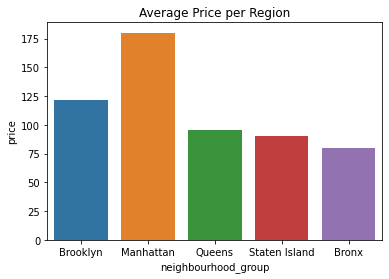

In [ ]:
# plot a barplot of the average price per region using seaborn
sns.barplot(x='neighbourhood_group', y='price', data=data, ci=None)

# set the title of the plot
plt.title('Average Price per Region')

# display the plot
plt.show()


#preprocessing

In [13]:
df = data

In [14]:
# define the number of folds
n_splits = 5

# initialize the KFold object
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# create an empty dataframe to store the encoded values
target_encoded = pd.DataFrame()

# loop over each fold
for train_index, test_index in kf.split(df):
    
    # create a copy of the dataframe
    train_df = df.iloc[train_index].copy()
    test_df = df.iloc[test_index].copy()
    
    # calculate the mean target value for each category in the training data
    mean_target = train_df.groupby('neighbourhood')['price'].mean()
    
    # apply the target encoding to the training and test data
    train_df['neighbourhood'] = train_df['neighbourhood'].map(mean_target)
    test_df['neighbourhood'] = test_df['neighbourhood'].map(mean_target)
    
    # add the encoded data to the target_encoded dataframe
    target_encoded = target_encoded.append(test_df)
    
# sort the target_encoded dataframe by index
target_encoded.sort_index(inplace=True)

print(target_encoded)


      neighbourhood_group  neighbourhood  latitude  longitude  \
0                Brooklyn      85.491525  40.64749  -73.97237   
1               Manhattan     263.976427  40.75362  -73.98377   
3                Brooklyn     178.866492  40.68514  -73.95976   
4               Manhattan     135.133075  40.79851  -73.94399   
5               Manhattan     218.144033  40.74767  -73.97500   
...                   ...            ...       ...        ...   
48782           Manhattan     167.688849  40.78099  -73.95366   
48790              Queens      83.206406  40.75104  -73.81459   
48799       Staten Island      87.000000  40.54179  -74.14275   
48805               Bronx      82.050000  40.80787  -73.92400   
48852            Brooklyn      84.337179  40.69805  -73.92801   

             room_type  price  minimum_nights  number_of_reviews  \
0         Private room    149               1                  9   
1      Entire home/apt    225               1                 45   
3      Entire h

<ipython-input-14-5518efe4b7f5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_encoded = target_encoded.append(test_df)
<ipython-input-14-5518efe4b7f5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_encoded = target_encoded.append(test_df)
<ipython-input-14-5518efe4b7f5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_encoded = target_encoded.append(test_df)
<ipython-input-14-5518efe4b7f5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_encoded = target_encoded.append(test_df)
<ipython-input-14-5518efe4b7f5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in 

In [15]:
df = target_encoded

In [16]:
prefixes = {'neighbourhood_group': 'area', 'room_type': 'category'}

# perform one hot encoding
one_hot_encoded = pd.get_dummies(df, prefix=prefixes, columns=['neighbourhood_group', 'room_type'])

# concatenate the encoded data with the original dataframe
df = pd.concat([one_hot_encoded], axis=1)

print(df)

       neighbourhood  latitude  longitude  price  minimum_nights  \
0          85.491525  40.64749  -73.97237    149               1   
1         263.976427  40.75362  -73.98377    225               1   
3         178.866492  40.68514  -73.95976     89               1   
4         135.133075  40.79851  -73.94399     80              10   
5         218.144033  40.74767  -73.97500    200               3   
...              ...       ...        ...    ...             ...   
48782     167.688849  40.78099  -73.95366    129               1   
48790      83.206406  40.75104  -73.81459     45               1   
48799      87.000000  40.54179  -74.14275    235               1   
48805      82.050000  40.80787  -73.92400    100               1   
48852      84.337179  40.69805  -73.92801     30               1   

       number_of_reviews  reviews_per_month  calculated_host_listings_count  \
0                      9               0.21                               6   
1                     45 

In [ ]:
df

,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,recency_of_review,area_Bronx,area_Brooklyn,area_Manhattan,area_Queens,area_Staten Island,category_Entire home/apt,category_Private room,category_Shared room
0,85.491525,40.64749,-73.97237,149,1,9,0.21,6,365,438.0,0,1,0,0,0,0,1,0
1,263.976427,40.75362,-73.98377,225,1,45,0.38,2,355,224.0,0,0,1,0,0,1,0,0
3,178.866492,40.68514,-73.95976,89,1,270,4.64,1,194,179.0,0,1,0,0,0,1,0,0
4,135.133075,40.79851,-73.94399,80,10,9,0.10,1,0,407.0,0,0,1,0,0,1,0,0
5,218.144033,40.74767,-73.97500,200,3,74,0.59,1,129,192.0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48782,167.688849,40.78099,-73.95366,129,1,1,1.00,1,147,177.0,0,0,1,0,0,0,1,0
48790,83.206406,40.75104,-73.81459,45,1,1,1.00,6,339,177.0,0,0,0,1,0,0,1,0
48799,87.000000,40.54179,-74.14275,235,1,1,1.00,1,87,177.0,0,0,0,0,1,0,1,0
48805,82.050000,40.80787,-73.92400,100,1,2,2.00,1,40,177.0,1,0,0,0,0,1,0,0


In [19]:
df = df.dropna()

In [ ]:
# check for missing values in the data
print(df.isnull().sum())

neighbourhood                     0
latitude                          0
longitude                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
recency_of_review                 0
area_Bronx                        0
area_Brooklyn                     0
area_Manhattan                    0
area_Queens                       0
area_Staten Island                0
category_Entire home/apt          0
category_Private room             0
category_Shared room              0
dtype: int64


In [ ]:
# create contingency table
contingency_table = pd.crosstab(df['price'], df['availability_365'])

# perform chi-square test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

# print results
print('Chi-square statistic:', chi2_stat)
print('P-value:', p_val)
print('Degrees of freedom:', dof)
print('Expected frequencies:', expected)


Chi-square statistic: 274185.0968256617
P-value: 0.0
Degrees of freedom: 211700
Expected frequencies: [[3.26547441 0.094573   0.06184611 ... 0.0425192  0.07756532 0.21671906]
 [3.91856929 0.11348761 0.07421533 ... 0.05102304 0.09307839 0.26006288]
 [0.32654744 0.0094573  0.00618461 ... 0.00425192 0.00775653 0.02167191]
 ...
 [0.32654744 0.0094573  0.00618461 ... 0.00425192 0.00775653 0.02167191]
 [0.65309488 0.0189146  0.01236922 ... 0.00850384 0.01551306 0.04334381]
 [0.65309488 0.0189146  0.01236922 ... 0.00850384 0.01551306 0.04334381]]


In [ ]:
# create contingency table
contingency_table = pd.crosstab(df['price'], df['calculated_host_listings_count'])

# perform chi-square test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

# print results
print('Chi-square statistic:', chi2_stat)
print('P-value:', p_val)
print('Degrees of freedom:', dof)
print('Expected frequencies:', expected)


Chi-square statistic: 122482.90723197116
P-value: 0.0
Degrees of freedom: 26680
Expected frequencies: [[6.52605267e+00 1.48198732e+00 6.42684121e-01 ... 1.10807607e-02
  7.21537907e-03 5.33422667e-02]
 [7.83126321e+00 1.77838479e+00 7.71220945e-01 ... 1.32969128e-02
  8.65845488e-03 6.40107200e-02]
 [6.52605267e-01 1.48198732e-01 6.42684121e-02 ... 1.10807607e-03
  7.21537907e-04 5.33422667e-03]
 ...
 [6.52605267e-01 1.48198732e-01 6.42684121e-02 ... 1.10807607e-03
  7.21537907e-04 5.33422667e-03]
 [1.30521053e+00 2.96397464e-01 1.28536824e-01 ... 2.21615214e-03
  1.44307581e-03 1.06684533e-02]
 [1.30521053e+00 2.96397464e-01 1.28536824e-01 ... 2.21615214e-03
  1.44307581e-03 1.06684533e-02]]


In [ ]:
# create contingency table
contingency_table = pd.crosstab(df['price'], df['minimum_nights'])

# perform chi-square test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

# print results
print('Chi-square statistic:', chi2_stat)
print('P-value:', p_val)
print('Degrees of freedom:', dof)
print('Expected frequencies:', expected)


Chi-square statistic: 104393.2679161635
P-value: 0.0
Degrees of freedom: 51040
Expected frequencies: [[2.54393650e+00 2.65294027e+00 1.76184095e+00 ... 5.15384219e-04
  5.15384219e-04 2.57692109e-04]
 [3.05272381e+00 3.18352832e+00 2.11420914e+00 ... 6.18461063e-04
  6.18461063e-04 3.09230531e-04]
 [2.54393650e-01 2.65294027e-01 1.76184095e-01 ... 5.15384219e-05
  5.15384219e-05 2.57692109e-05]
 ...
 [2.54393650e-01 2.65294027e-01 1.76184095e-01 ... 5.15384219e-05
  5.15384219e-05 2.57692109e-05]
 [5.08787301e-01 5.30588053e-01 3.52368190e-01 ... 1.03076844e-04
  1.03076844e-04 5.15384219e-05]
 [5.08787301e-01 5.30588053e-01 3.52368190e-01 ... 1.03076844e-04
  1.03076844e-04 5.15384219e-05]]


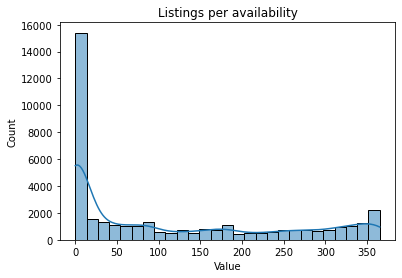

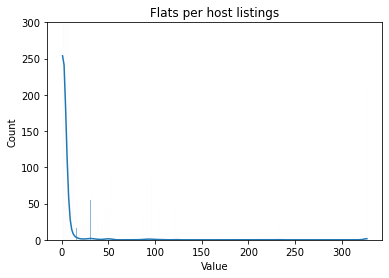

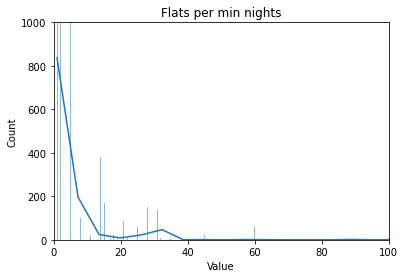

In [ ]:
sns.histplot(data['availability_365'], kde=True)

# add labels and title
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Listings per availability')

# show the plot
plt.show()

sns.histplot(data['calculated_host_listings_count'], kde=True)

# add labels and title
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Flats per host listings')
plt.ylim(0,300)
# show the plot
plt.show()

sns.histplot(data['minimum_nights'], kde=True)

# add labels and title
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Flats per min nights')
plt.ylim(0,1000)
plt.xlim(0,100)
# show the plot
plt.show()

In [21]:
# Define a function to apply the condition

def condition_short_stay(x):
    if x < 2:
        return 1
    else:
        return 0

# Apply the function to create a new column based on the condition
df['Short_stay'] = df['minimum_nights'].apply(condition_short_stay)

In [22]:
# Define a function to apply the condition
def condition_unfrequent_host(x):
    if x < 10:
        return 1
    else:
        return 0

# Apply the function to create a new column based on the condition
df['Unfrequent_host'] = df['calculated_host_listings_count'].apply(condition_unfrequent_host)

In [23]:
# Define a function to apply the condition
def condition_generally_available(x):
    if x > 30:
        return 1
    else:
        return 0

# Apply the function to create a new column based on the condition
df['Availability'] = df['availability_365'].apply(condition_generally_available)

In [24]:
#normalize the numerical feature
col = ['minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','recency_of_review','availability_365']
qt = QuantileTransformer(output_distribution='normal')
df[col] = qt.fit_transform(df[col])
df['price'] = np.log(df['price']+1)

#model

In [ ]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('price', axis=1), df['price'], test_size=0.3, random_state=42)

In [59]:
#decision tree
dt = DecisionTreeRegressor(max_depth = 8,min_samples_leaf =4, min_samples_split = 2)

# Fit the model to the training data
dt.fit(X_train, y_train)

# Use the trained model to make predictions on the test data
y_pred = dt.predict(X_test)

# Calculate the R-squared score on the test data
mae = mean_absolute_error(np.exp(y_test), np.exp(y_pred))
rmse = mean_squared_error(np.exp(y_test), np.exp(y_pred),squared=False)
r2 = r2_score(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R2 Score: {r2}')

Mean Absolute Error: 52.691792219171596
Root Mean Squared Error: 213.66712959459994
R2 Score: 0.5738306518802991


In [67]:
#dt for adaboost
dt2 = DecisionTreeRegressor(max_depth = 3)

# Fit the model to the training data
dt2.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3)

In [58]:
param_grid = {
    'max_depth': [8, 10, 12],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
}

# Create a Random Forest Regressor
dt_model = DecisionTreeRegressor()
'''
scoring = {'mse': make_scorer(mean_squared_error),
           'r2': make_scorer(r2_score),
           'mae':make_scorer(mean_absolute_error)}
'''
scoring = make_scorer(mean_squared_error, squared=False)
# Use Grid Search to find the best hyperparameters
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and R-squared score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score:", np.sqrt(grid_search.best_score_))


Best hyperparameters:  {'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best score: 0.752478382185417


In [33]:
# initialize the random forest regressor
rf = RandomForestRegressor(n_estimators=250, max_depth=15, min_samples_leaf=2, min_samples_split=2, random_state=42)

# fit the model to the training data
rf.fit(X_train, y_train)

# make predictions on the test data
y_pred = rf.predict(X_test)

# calculate the mean squared error and R^2 score of the model
mae = mean_absolute_error(np.exp(y_test), np.exp(y_pred))
rmse = mean_squared_error(np.exp(y_test), np.exp(y_pred),squared=False)
r2 = r2_score(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {rmse}')
print(f'R2 Score: {r2}')


Mean Absolute Error: 49.0937724414119
Mean Squared Error: 210.12093407607279
R2 Score: 0.6248637585568588


In [63]:
param_grid = {
    'n_estimators':[200,250],
    'max_depth': [12,15],
    'min_samples_split': [2],
    'min_samples_leaf': [2],
}

# Create a Random Forest Regressor
rf_model = RandomForestRegressor()

# Use Grid Search to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='r2')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and R-squared score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score:", np.sqrt(grid_search.best_score_))

Best hyperparameters:  {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 250}
Best score: 0.7824710044045566


In [72]:
#adaboost
ada = AdaBoostRegressor(n_estimators=100, learning_rate=0.05, random_state=42)

# Fit the AdaBoost regressor to the training data
ada.fit(X_train, y_train)

# Evaluate the performance of the AdaBoost regressor on the testing data
y_pred = ada.predict(X_test)
mae = mean_absolute_error(np.exp(y_test), np.exp(y_pred))
rmse = mean_squared_error(np.exp(y_test), np.exp(y_pred),squared=False)
r2 = r2_score(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {rmse}')
print(f'R2 Score: {r2}')

Mean Absolute Error: 54.2198982259249
Mean Squared Error: 214.36635743018996
R2 Score: 0.5355518170090099


In [75]:
ada = AdaBoostRegressor(base_estimator=dt2,n_estimators=80, learning_rate=0.05, random_state=42)

# Fit the AdaBoost regressor to the training data
ada.fit(X_train, y_train)

# Evaluate the performance of the AdaBoost regressor on the testing data
y_pred = ada.predict(X_test)

mae = mean_absolute_error(np.exp(y_test), np.exp(y_pred))
rmse = mean_squared_error(np.exp(y_test), np.exp(y_pred),squared=False)
r2 = r2_score(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {rmse}')
print(f'R2 Score: {r2}')

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Mean Absolute Error: 54.15478680797206
Mean Squared Error: 214.50406347756697
R2 Score: 0.5370085083424622


In [82]:
gb_model = GradientBoostingRegressor(n_estimators=150, learning_rate=0.05, max_depth=10, random_state=42)

# Train the model
gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X_test)

mae = mean_absolute_error(np.exp(y_test), np.exp(y_pred))
rmse = mean_squared_error(np.exp(y_test), np.exp(y_pred),squared=False)
r2 = r2_score(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {rmse}')
print(f'R2 Score: {r2}')

Mean Absolute Error: 49.734201284411455
Mean Squared Error: 211.30672268891172
R2 Score: 0.6214007567107368


In [87]:
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=8, random_state=42)

# Train the model
gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X_test)

mae = mean_absolute_error(np.exp(y_test), np.exp(y_pred))
rmse = mean_squared_error(np.exp(y_test), np.exp(y_pred),squared=False)
r2 = r2_score(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {rmse}')
print(f'R2 Score: {r2}')

Mean Absolute Error: 49.75113337944032
Mean Squared Error: 211.63845383026202
R2 Score: 0.620528623817066


In [84]:
param_grid = {
    'n_estimators':[100,120,150],
    'max_depth': [8,10,12],
}

# Create a Gradient Boosting Regressor
gb_model = GradientBoostingRegressor()

# Use Grid Search to find the best hyperparameters
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=3, scoring='r2')
grid_search.fit(X_train, y_train)


# Print the best hyperparameters and R-squared score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score:", np.sqrt(grid_search.best_score_))

Best hyperparameters:  {'max_depth': 8, 'n_estimators': 100}
Best score: 0.7794773745497559


In [77]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=180, max_depth=12, learning_rate=0.05, random_state=42)

# Train the model on the training set
xgb_model.fit(X_train, y_train)

# Make predictions on the training and testing sets

y_pred = xgb_model.predict(X_test)

mae = mean_absolute_error(np.exp(y_test), np.exp(y_pred))
rmse = mean_squared_error(np.exp(y_test), np.exp(y_pred),squared=False)
r2 = r2_score(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {rmse}')
print(f'R2 Score: {r2}')

Mean Absolute Error: 49.19185726091561
Mean Squared Error: 208.0839384579554
R2 Score: 0.6256244484620958


In [92]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=150, max_depth=10, learning_rate=0.05, random_state=42)

# Train the model on the training set
xgb_model.fit(X_train, y_train)

# Make predictions on the training and testing sets

y_pred = xgb_model.predict(X_test)

mae = mean_absolute_error(np.exp(y_test), np.exp(y_pred))
rmse = mean_squared_error(np.exp(y_test), np.exp(y_pred),squared=False)
r2 = r2_score(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {rmse}')
print(f'R2 Score: {r2}')

Mean Absolute Error: 48.70265705233473
Mean Squared Error: 208.4971990789434
R2 Score: 0.6313459281554286


In [89]:
param_grid = {
    'n_estimators':[150,180,200],
    'max_depth': [10,12,15],
    'learning_rate':[0.05]
}

# Create a Random Forest Regressor
xgb_model = xgb.XGBRegressor()

# Use Grid Search to find the best hyperparameters
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='r2')
grid_search.fit(X_train, y_train)


# Print the best hyperparameters and R-squared score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score:", np.sqrt(grid_search.best_score_))

Best hyperparameters:  {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 150}
Best score: 0.7844434625845648
